# Loading and Preprocessing Data with TensorFlow

### Libraries

In [1]:
import numpy as np
from pathlib import Path
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example
from tensorflow.train import FeatureList, FeatureLists, SequenceExample

import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

### The tf.data API

In [2]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [3]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [4]:
X_nested = {"a": ([1, 2, 3], [4, 5, 6]), "b": [7, 8, 9]}
X_nested

{'a': ([1, 2, 3], [4, 5, 6]), 'b': [7, 8, 9]}

In [5]:
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


### Chaining Transformations

In [6]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)

In [7]:
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [8]:
# tf.data.Dataset.from_tensor_slices()

In [9]:
dataset = dataset.map(lambda x: x * 2)
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [10]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


In [11]:
# More like pandas head.
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


### Shuffling the Data

In [12]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([1 4 2 3 5 0 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 2 0 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 6 7 8], shape=(6,), dtype=int64)


### Interleaving Lines from Multiple Files

In [13]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [14]:
def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths


train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

In [15]:
train_filepaths

['datasets\\housing\\my_train_00.csv',
 'datasets\\housing\\my_train_01.csv',
 'datasets\\housing\\my_train_02.csv',
 'datasets\\housing\\my_train_03.csv',
 'datasets\\housing\\my_train_04.csv',
 'datasets\\housing\\my_train_05.csv',
 'datasets\\housing\\my_train_06.csv',
 'datasets\\housing\\my_train_07.csv',
 'datasets\\housing\\my_train_08.csv',
 'datasets\\housing\\my_train_09.csv',
 'datasets\\housing\\my_train_10.csv',
 'datasets\\housing\\my_train_11.csv',
 'datasets\\housing\\my_train_12.csv',
 'datasets\\housing\\my_train_13.csv',
 'datasets\\housing\\my_train_14.csv',
 'datasets\\housing\\my_train_15.csv',
 'datasets\\housing\\my_train_16.csv',
 'datasets\\housing\\my_train_17.csv',
 'datasets\\housing\\my_train_18.csv',
 'datasets\\housing\\my_train_19.csv']

Building an Input Pipeline

In [16]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_15.csv', sh

In [17]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

In [18]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418', shape=(), dtype=string)
tf.Tensor(b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0', shape=(), dtype=string)
tf.Tensor(b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67', shape=(), dtype=string)
tf.Tensor(b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205', shape=(), dtype=string)
tf.Tensor(b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215', shape=(), dtype=string)


### Preprocessing the Data

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [20]:
X_mean, X_std = scaler.mean_, scaler.scale_  # extra code
n_inputs = 8

In [21]:
def parse_csv_line(line):
    # Default values, [tf.constant([], dtype=tf.float32)] tells TF that this column contains
    # floats but there is no default value, throw error if empty.
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

In [22]:
X_mean

array([ 3.89175860e+00,  2.86245478e+01,  5.45593655e+00,  1.09963474e+00,
        1.42428122e+03,  2.95886657e+00,  3.56464315e+01, -1.19584363e+02])

In [23]:
def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

In [24]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

### Putting Everything Together

In [25]:
def csv_reader_dataset(
        filepaths, n_readers=5, n_read_threads=None, 
        n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

### Using the Dataset with Keras

In [26]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
363/363 [==============================] - 2s 3ms/step - loss: 0.7297 - val_loss: 0.5139
Epoch 2/5
363/363 [==============================] - 1s 1ms/step - loss: 0.5109 - val_loss: 0.5435
Epoch 3/5
363/363 [==============================] - 1s 1ms/step - loss: 0.4748 - val_loss: 0.8697
Epoch 4/5
363/363 [==============================] - 1s 1ms/step - loss: 0.5223 - val_loss: 0.4432
Epoch 5/5
363/363 [==============================] - 1s 1ms/step - loss: 0.4421 - val_loss: 3.3861


In [29]:
test_mse = model.evaluate(test_set)
new_set = test_set.take(3) # pretend we have 3 new samples
y_pred = model.predict(new_set) 

3/3 [==============================] - 0s 6ms/step


In [30]:
n_epochs = 5

In [31]:
@tf.function
def train_one_epoch(model, optimizer, loss_fn, train_set):
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
for epoch in range(n_epochs):
    print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
    train_one_epoch(model, optimizer, loss_fn, train_set)

Epoch 5/5

### The TFRecord Format

In [32]:
with tf.io.TFRecordWriter("datasets/tfrecords/my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [33]:
filepaths = ['datasets/tfrecords/my_data.tfrecord']
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


### Compressed TFRecord Files

In [34]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("datasets/tfrecords/my_compressed.tfrecord", options) as f:
    f.write(b"Yay, Yay, yay!")

In [35]:
dataset = tf.data.TFRecordDataset(["datasets/tfrecords/my_compressed.tfrecord"], compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'Yay, Yay, yay!', shape=(), dtype=string)


### A Brief Introduction to Protocol Buffers

In [36]:
%%writefile datasets/person.proto

syntax = "proto3";
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}

Overwriting datasets/person.proto


In [37]:
!protoc datasets/person.proto --python_out=. --descriptor_set_out=datasets/person.desc --include_imports

In [38]:
from datasets.person_pb2 import Person

In [39]:
person = Person(name="Al", id=123, email=["a@b.com"])
person

name: "Al"
id: 123
email: "a@b.com"

In [40]:
person.name

'Al'

In [41]:
person.SerializeToString()

b'\n\x02Al\x10{\x1a\x07a@b.com'

In [42]:
serialized = person.SerializeToString()
serialized

b'\n\x02Al\x10{\x1a\x07a@b.com'

### TensorFlow Protobufs

Here is the definition of the tf.train.Example protobuf:

```
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

In [43]:
person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
             "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }
    )
)

In [44]:
with tf.io.TFRecordWriter("datasets/my_contacts.tfrecord") as f:
    for _ in range(5):
        f.write(person_example.SerializeToString())

### Loading and Parsing Examples

In [45]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

feature_description

{'name': FixedLenFeature(shape=[], dtype=tf.string, default_value=''),
 'id': FixedLenFeature(shape=[], dtype=tf.int64, default_value=0),
 'emails': VarLenFeature(dtype=tf.string)}

In [46]:
def parse(serialized_example):
    return tf.io.parse_single_example(serialized_example, feature_description)

In [47]:
dataset = tf.data.TFRecordDataset(["datasets/my_contacts.tfrecord"]).map(parse)

In [48]:
for parsed_example in dataset:
    print(parsed_example)

{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tenso

In [49]:
parsed_example["emails"]

SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64))

In [50]:
 tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [51]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [52]:
def parse(serialized_examples):
    return tf.io.parse_example(serialized_examples, feature_description)

In [53]:
dataset = tf.data.TFRecordDataset(["datasets/my_contacts.tfrecord"]).batch(2).map(parse)

In [54]:
for parsed_examples in dataset:
    print(parsed_examples)

{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com' b'a@b.com' b'c@d.com'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123], dtype=int64)>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com' b'a@b.com' b'c@d.com'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123], dtype=int64)>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=s

### Storing Images and Tensors in TFRecords

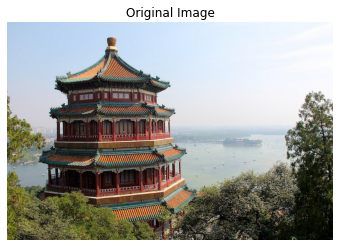

In [55]:
img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [56]:
data = tf.io.encode_jpeg(img)
# data

In [57]:
example_with_image = Example(
    features=Features(
        feature={"image": Feature(bytes_list = BytesList(value=[data.numpy()]))
    })
)

In [58]:
serialized_example = example_with_image.SerializeToString()
with tf.io.TFRecordWriter("datasets/my_image.tfrecord") as f:
    f.write(serialized_example)

In [59]:
feature_description = { "image": tf.io.VarLenFeature(tf.string)}

In [60]:
def parse(serialized_example):
    example_with_image = tf.io.parse_single_example(serialized_example, feature_description)
    return tf.io.decode_jpeg(example_with_image["image"].values[0])

In [61]:
dataset = tf.data.TFRecordDataset("datasets/my_image.tfrecord").map(parse)

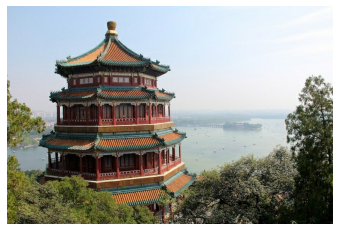

In [62]:
for image in dataset:
    plt.imshow(image)
    plt.axis("off")
    plt.show()

### Handling Lists of Lists Using the SequenceExample Protobuf

```
message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
     Features context = 1;
     FeatureLists feature_lists = 2;
};
```

In [63]:
context = Features(
    feature={
        "author_id": Feature(int64_list=Int64List(value=[123])),
        "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
        "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
    })

In [64]:
content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

In [65]:
content[0]

['When', 'shall', 'we', 'three', 'meet', 'again', '?']

In [66]:
def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8") for word in words]))

In [67]:
content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]

In [68]:
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(
        feature_list={
            "content": FeatureList(feature=content_features),
            "comments": FeatureList(feature=comments_features)
        }
    )
)

sequence_example

### Keras Preprocessing Layers

#### The Normalization Layer

In [69]:
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.models.Sequential([
    norm_layer,
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
norm_layer.adapt(X_train) # computes the mean and variance of every feature
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 1ms/step - loss: 2.9917 - val_loss: 1.8092
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.8071 - val_loss: 1.4167
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6727 - val_loss: 1.2344
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6394 - val_loss: 0.8520
Epoch 5/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6179 - val_loss: 0.5877


In [70]:
# Move normalization out of the model.
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

In [71]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 [==============================] - 1s 1ms/step - loss: 2.9497 - val_loss: 0.8874
Epoch 2/5
363/363 [==============================] - 0s 875us/step - loss: 0.6930 - val_loss: 1.8800
Epoch 3/5
363/363 [==============================] - 0s 915us/step - loss: 0.6020 - val_loss: 1.1170
Epoch 4/5
363/363 [==============================] - 0s 999us/step - loss: 0.5814 - val_loss: 0.7789
Epoch 5/5
363/363 [==============================] - 0s 850us/step - loss: 0.5725 - val_loss: 0.5443


In [72]:
final_model = tf.keras.Sequential([norm_layer, model])
final_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 8)                17        
 ion)                                                            
                                                                 
 sequential_2 (Sequential)   (None, 1)                 9         
                                                                 
Total params: 26
Trainable params: 9
Non-trainable params: 17
_________________________________________________________________


In [73]:
X_new = X_test[:3] # pretend we have a few new instances (unscaled)
y_pred = final_model(X_new) # preprocesses the data and makes predictions

### The Discretization Layer

In [74]:
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18., 50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]], dtype=int64)>

### The CategoryEncoding Layer

In [75]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)>

In [77]:
two_age_categories = np.array([[1, 0], [2, 2], [2, 0]])
two_age_categories

array([[1, 0],
       [2, 2],
       [2, 0]])

### The StringLookup Layer

In [78]:
cities = ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)

In [79]:
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [3],
       [3],
       [0]], dtype=int64)>

In [80]:
str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)>

In [81]:
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[5],
       [7],
       [4],
       [3],
       [4]], dtype=int64)>

### The Hashing Layer

In [82]:
hashing_layer = tf.keras.layers.Hashing(num_bins=10)
hashing_layer([["Paris"], ["Tokyo"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[0],
       [1],
       [9],
       [1]], dtype=int64)>

### Encoding Categorical Features Using Embeddings

In [83]:
tf.random.set_seed(42)
embedding_layer = tf.keras.layers.Embedding(input_dim=5, output_dim=2)
embedding_layer(np.array([2, 4, 2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.04459784, -0.02893173],
       [-0.03232168,  0.02317626],
       [ 0.04459784, -0.02893173]], dtype=float32)>

In [90]:
tf.random.set_seed(42)
ocean_prox = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)

In [96]:
lookup_and_embed = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[], dtype=tf.string), 
    str_lookup_layer, 
    tf.keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(), output_dim=2)
])

In [97]:
lookup_and_embed(np.array([["<1H OCEAN"], ["ISLAND"], ["<1H OCEAN"]]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.02341032,  0.02469417],
       [-0.02948991, -0.03524603],
       [-0.02341032,  0.02469417]], dtype=float32)>

### Text Preprocessing

In [99]:
train_data = ["To be", "!(to be)", "That's the question", "Be, be, be."]
text_vec_layer = tf.keras.layers.TextVectorization()
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [6, 2, 1, 2]], dtype=int64)>

In [100]:
text_vec_layer = tf.keras.layers.TextVectorization(output_mode="tf_idf")
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.96725637, 0.6931472 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.96725637, 1.3862944 , 0.        , 0.        , 0.        ,
        1.0986123 ]], dtype=float32)>